# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [14]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [15]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [16]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = 4)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [17]:
estimator = Estimator()

/home/ncng/.local/share/virtualenvs/VQA-Notes-v2-sVJD73WG/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


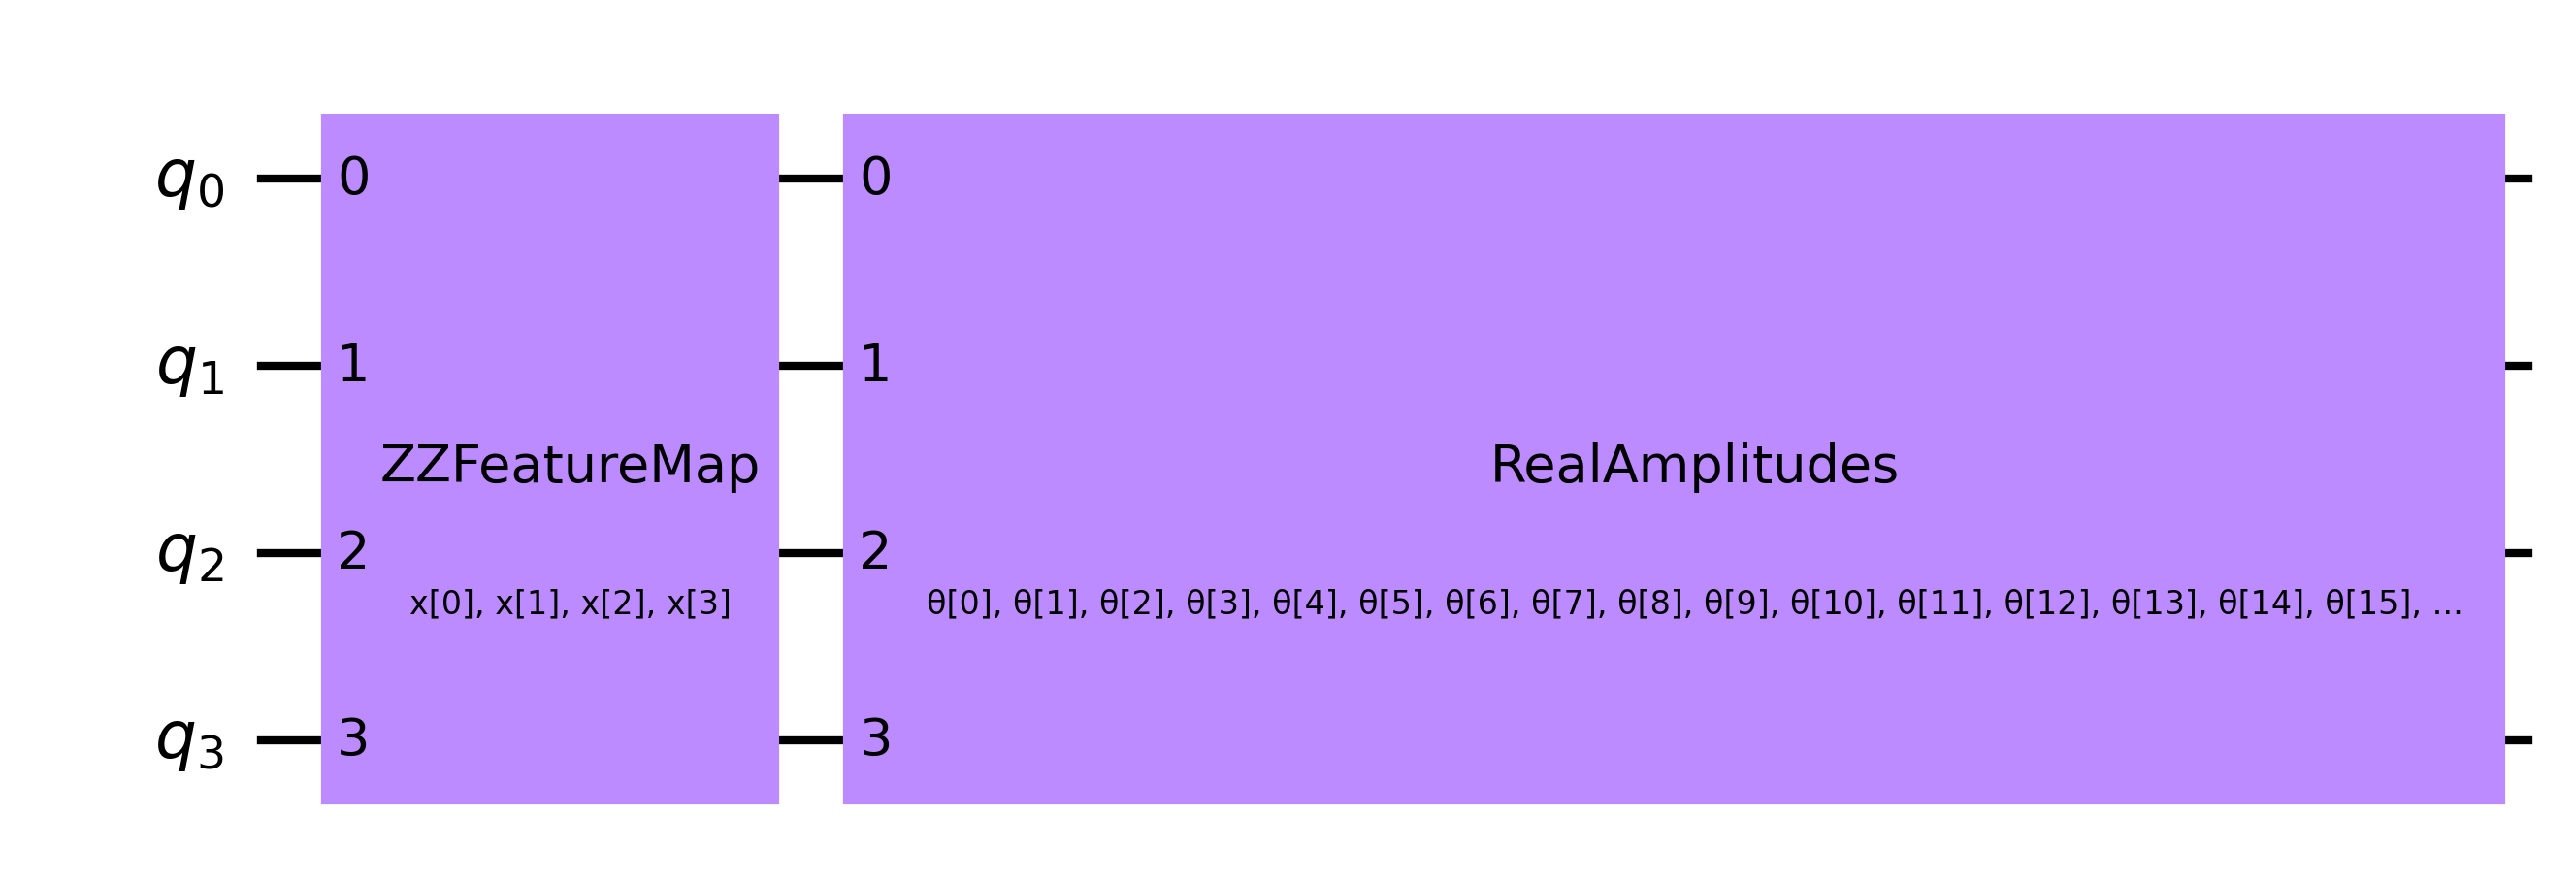

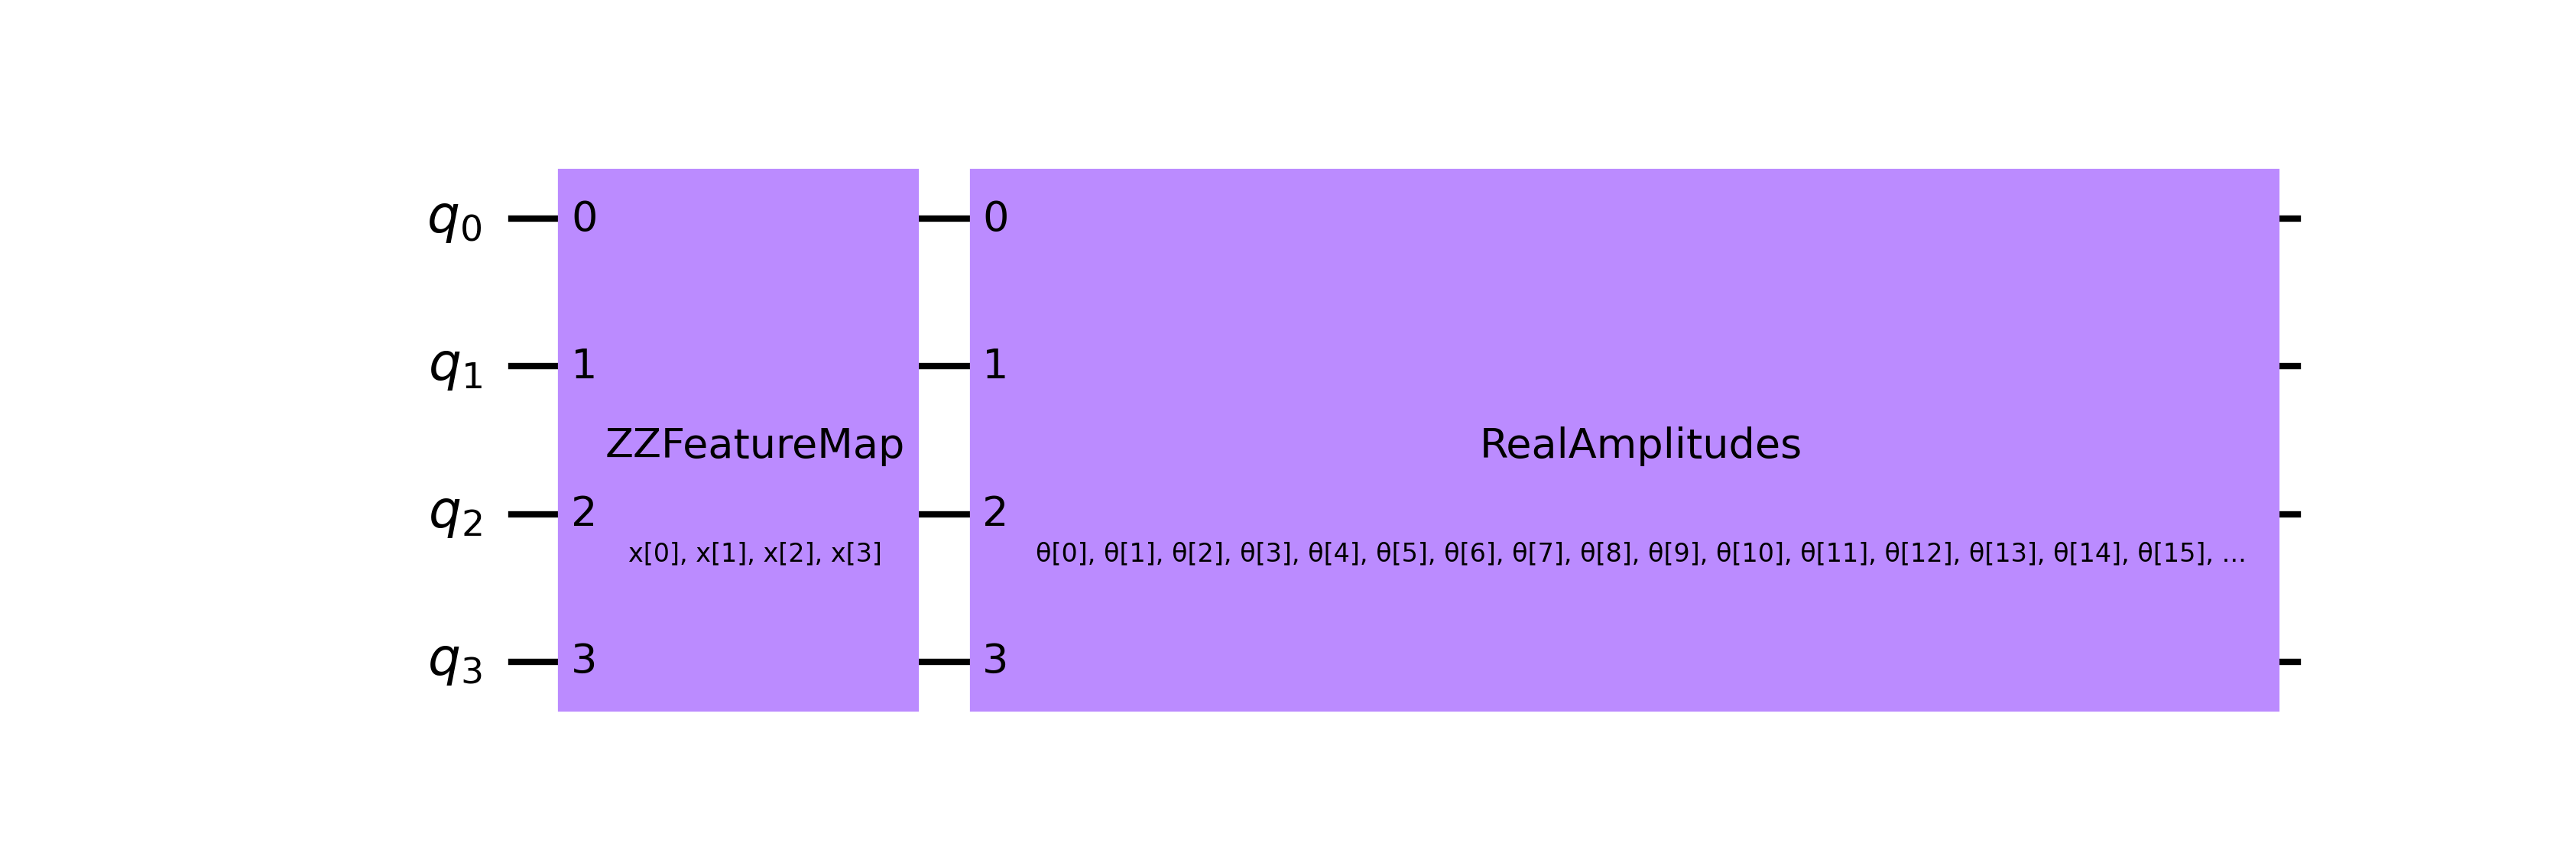

In [18]:
feature_map = featureMapGenerator(4)
ansatz = AnsatzGenerator(4, 4, ENTANGLEMENT)

qc = circuitBuilder(feature_map, ansatz, 'middle')
qc.draw('mpl')

In [19]:
randompoint = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [20]:
# print('randompoint = ', randompoint)
# X = np.arange(-np.pi, np.pi, 0.25)
# Y = np.arange(-np.pi, np.pi, 0.25)
# X, Y = np.meshgrid(X, Y)
# for x in X[0, :]:
#     for y in Y[:, 0]:
#         rotations = np.array([x, y])
#         print(rotations)

res = pd.DataFrame()

GLOBAL_OPERATOR = SparsePauliOp.from_list([('Z'*qc.num_qubits, 1)])

initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

for i in range(0, 20):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)


iteration:  3


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.559264,0.946305,1.433955,1.486296,0.264534,1.389944,0.711472,0.313823,0.654996,1.495150,...,0.434142,0.919071,0.369376,0.060433,0.175298,0.201817,0.276687,0.125932,1.066566,1.094877
1,0.648468,0.893523,1.429313,1.575678,0.143238,1.410856,0.834255,0.455301,0.658113,1.481301,...,0.513306,1.018595,0.351003,0.111673,0.251938,0.108471,0.189096,0.260739,1.085725,1.094982
2,0.625223,0.983594,1.276032,1.480986,0.237546,1.403975,0.726863,0.381106,0.625223,1.503847,...,0.481901,0.918896,0.455325,0.137884,0.238264,0.258968,0.238297,0.135453,1.014105,1.110195


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(res).to_csv('./bp-visualise/point-mae.csv')

In [22]:
data = pd.read_csv('Logs-Cancer-v4/m3/LossFunctionSurface.csv', index_col=0)
parameters = data.iloc[:,:-1]
maes = data.iloc[:,-1]


In [23]:
pca = PCA(n_components=2)
pca.fit(parameters)
principalData = pca.transform(parameters)
print(pca.explained_variance_ratio_)
principalDataDF = pd.DataFrame(principalData, columns=['x', 'y'])
principalDataDF['z'] = maes

[0.09484725 0.086244  ]


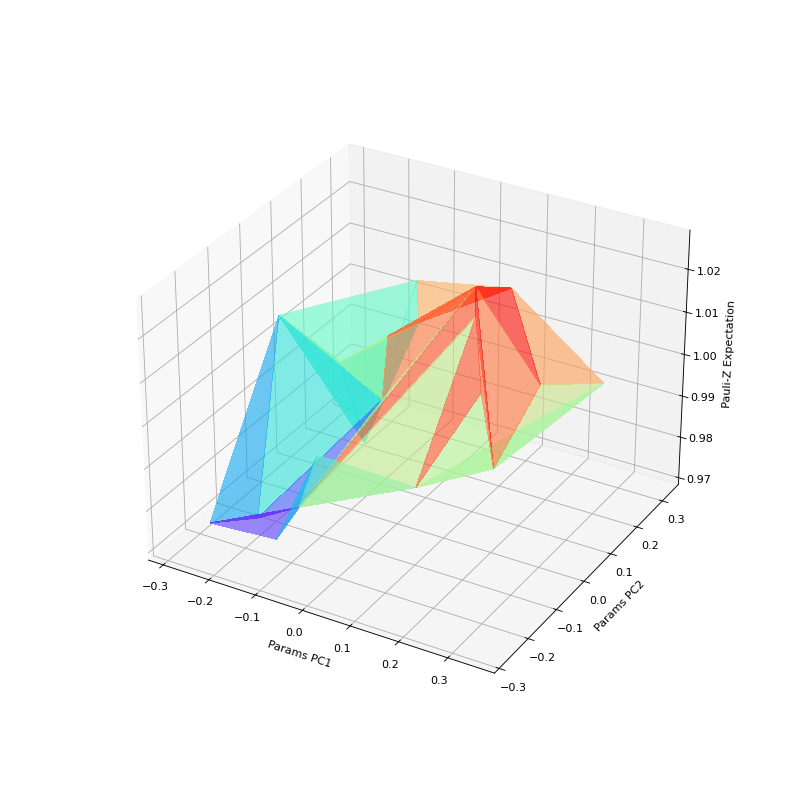

In [24]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
xs = principalDataDF['x']
ys = principalDataDF['y']
zs = principalDataDF['z']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Params PC1')
ax.set_ylabel('Params PC2')
ax.set_zlabel('Pauli-Z Expectation')

plot = ax.plot_trisurf(xs,
                       ys,
                       zs,
                       cmap=plt.get_cmap('rainbow'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)

plt.show()